# Part 3: Modeling & Evaluation

This notebook trains, tunes, and evaluates multiple machine learning models to predict product reorders using the engineered dataset (`df.pkl`).  
It addresses the severe class imbalance in the data and selects the best model based on F1 score, recall, and interpretability.

## Files Used (inputs)

- `df.pkl` – Final modeling dataset with merged labels and features, no missing values

## Outputs

- Trained models: **XGBoost**, **LightGBM**, **CatBoost**  
- Model evaluation metrics and confusion matrices  
- Feature importance analysis (SHAP values)  
- Recommended production model configuration


## Workflow Summary

### 1) Data preparation
- Dropped identifier columns (`user_id`, `product_id`, `order_id`) and non-numeric/categorical fields (`aisle`, `department`, `prod_reorder_prob`).
- Separated `X` (features) and `y` (target `reordered`).
- Filled remaining numeric NaNs with `0`.
- Performed an **80/20 stratified split** to preserve class balance in train/validation sets.


### 2) Baseline XGBoost
- Trained **XGBoost** with default parameters.
- Initial results (threshold = 0.50) showed:
  - **High precision** for class 1 (~0.64) but **low recall** (~0.19) due to imbalance (~9:1).
- Identified need for imbalance handling.


### 3) Class imbalance handling
Applied multiple strategies to improve recall and F1 score for the minority class:
1. **Threshold tuning** – Lowered probability threshold to increase positive predictions (best at 0.35).
2. **Built-in class weighting** – Used `scale_pos_weight` in XGBoost to balance loss function contributions.
3. **Random undersampling** – Reduced class 0 instances in training to 0.5:1 ratio vs class 1.


### 4) Model variants tested

#### a) XGBoost with threshold tuning
- Best threshold: **0.35**  
- Achieved **F1 ≈ 0.40**, improved recall while keeping decent precision.

#### b) XGBoost with `scale_pos_weight`
- Balanced recall and precision more evenly at higher thresholds.
- Improved recall up to ~0.75 but with precision drop.

#### c) XGBoost with undersampling
- Best threshold: **0.40**  
- Achieved **F1 ≈ 0.41**, recall ~0.68, precision ~0.29 for class 1.

#### d) LightGBM
- Tuned with early stopping.  
- Best threshold: **0.23**  
- Achieved **F1 ≈ 0.45** (best among models), recall ~0.49, precision ~0.41 for class 1.

#### e) CatBoost
- Tuned with early stopping.  
- Best threshold: **0.22**  
- Achieved **F1 ≈ 0.45**, recall ~0.50, precision ~0.40 for class 1.

### 5) Model interpretation (SHAP analysis)
- Computed SHAP values for XGBoost model.  
- Top predictors:
  - `user_reorder_ratio`
  - `days_since_prior_order`
  - `product_reorder_rate`
  - `user_avg_basket_size`
- Feature importance was consistent across boosting models.

### 6) Model selection
- **Chosen model:** **LightGBM (threshold = 0.23)**  
  - Highest F1 score (~0.4495) on validation.  
  - Balanced recall (~0.49) and precision (~0.41).  
  - Faster training time than XGBoost with comparable interpretability.  
  - Good candidate for production and further tuning/ensembling.

## Result
- Trained and compared **three boosting algorithms** with imbalance handling.
- LightGBM emerged as the best single model for reorder prediction.
- SHAP analysis confirmed that both user behavior and product-level metrics are key drivers.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import entropy
import sys

In [3]:
df = pd.read_pickle('df.pkl')

XGBOOST

In [5]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

# Drop ID, target, and categorical columns
drop_cols = ['user_id', 'product_id', 'order_id', 'reordered', 'aisle', 'department', 'prod_reorder_prob ']
X = df.drop(columns=drop_cols, errors='ignore').fillna(0)
y = df['reordered']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Train XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\n ROC–AUC Score:")
print(roc_auc_score(y_val, y_pred_proba))

/usr/local/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95   1529168
         1.0       0.64      0.19      0.29    165765

    accuracy                           0.91   1694933
   macro avg       0.78      0.59      0.62   1694933
weighted avg       0.89      0.91      0.89   1694933


 Confusion Matrix:
[[1511885   17283]
 [ 134984   30781]]

 ROC–AUC Score:
0.8348134274735096


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict probabilities instead of labels
y_proba = model.predict_proba(X_val)[:, 1]

# Set a custom threshold (e.g., 0.30 instead of default 0.50)
custom_threshold = 0.35
y_pred_custom = (y_proba >= custom_threshold).astype(int)

# Evaluate performance
print(" Classification Report (Threshold = 0.30):")
print(classification_report(y_val, y_pred_custom))

print("\n Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_custom))

print("\n ROC–AUC Score:")
print(roc_auc_score(y_val, y_proba))

 Classification Report (Threshold = 0.30):
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95   1529168
         1.0       0.52      0.33      0.40    165765

    accuracy                           0.90   1694933
   macro avg       0.73      0.65      0.67   1694933
weighted avg       0.89      0.90      0.89   1694933


 Confusion Matrix:
[[1479318   49850]
 [ 111601   54164]]

 ROC–AUC Score:
0.8348134274735096


XGBoost Built-in Weighting

In [8]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

# Drop ID, target, and categorical columns 
drop_cols = ['user_id', 'product_id', 'order_id', 'reordered', 'aisle', 'department', 'prod_reorder_prob ']
X = df.drop(columns=drop_cols, errors='ignore').fillna(0)
y = df['reordered']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Calculate scale_pos_weight = #negative / #positive
neg, pos = (y == 0).sum(), (y == 1).sum()
scale_pos_weight = neg / pos

print(f"scale_pos_weight: {scale_pos_weight:.2f}")  # should be ~9.2 or similar for your case

# Define model with the weight
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit as usual
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

print(" Classification Report:")
print(classification_report(y_val, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\n ROC–AUC Score:")
print(roc_auc_score(y_val, y_pred_proba))

scale_pos_weight: 9.22


/usr/local/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85   1529168
         1.0       0.25      0.75      0.38    165765

    accuracy                           0.76   1694933
   macro avg       0.61      0.76      0.61   1694933
weighted avg       0.90      0.76      0.80   1694933


 Confusion Matrix:
[[1160894  368274]
 [  41270  124495]]

 ROC–AUC Score:
0.8349437261415928


In [9]:
from sklearn.metrics import f1_score

thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    print(f"\n Threshold = {t}")
    print(classification_report(y_val, y_pred_thresh))
    print("F1 score (class 1):", f1_score(y_val, y_pred_thresh))



 Threshold = 0.3
              precision    recall  f1-score   support

         0.0       0.98      0.54      0.69   1529168
         1.0       0.17      0.90      0.29    165765

    accuracy                           0.57   1694933
   macro avg       0.58      0.72      0.49   1694933
weighted avg       0.90      0.57      0.65   1694933

F1 score (class 1): 0.2906652775013755

 Threshold = 0.35
              precision    recall  f1-score   support

         0.0       0.98      0.60      0.74   1529168
         1.0       0.19      0.87      0.31    165765

    accuracy                           0.63   1694933
   macro avg       0.58      0.73      0.53   1694933
weighted avg       0.90      0.63      0.70   1694933

F1 score (class 1): 0.31207562444316395

 Threshold = 0.4
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.79   1529168
         1.0       0.21      0.83      0.33    165765

    accuracy                           0.68   16

undersampling majority class (class 0) using RandomUnderSampler

In [11]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import shap

# Drop ID, target, and categorical columns 
drop_cols = ['user_id', 'product_id', 'order_id', 'reordered', 'aisle', 'department', 'prod_reorder_prob ']
X = df.drop(columns=drop_cols, errors='ignore').fillna(0)
y = df['reordered']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Undersample majority class (class 0) 
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Train XGBoost on resampled data 
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_res, y_res)

# Evaluate on original validation set
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

print(" Classification Report:")
print(classification_report(y_val, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\n ROC–AUC Score:")
print(roc_auc_score(y_val, y_pred_proba))

/usr/local/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:14:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92   1529168
         1.0       0.35      0.58      0.44    165765

    accuracy                           0.86   1694933
   macro avg       0.65      0.73      0.68   1694933
weighted avg       0.89      0.86      0.87   1694933


 Confusion Matrix:
[[1354298  174870]
 [  70210   95555]]

 ROC–AUC Score:
0.8348989824295014


In [12]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.6, 0.05)

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    print(f"\n Threshold = {thresh:.2f}")
    print(classification_report(y_val, y_pred_thresh))
    print(f"F1 score (class 1): {f1_score(y_val, y_pred_thresh):.4f}")



 Threshold = 0.10
              precision    recall  f1-score   support

         0.0       0.99      0.34      0.51   1529168
         1.0       0.14      0.96      0.24    165765

    accuracy                           0.40   1694933
   macro avg       0.56      0.65      0.37   1694933
weighted avg       0.90      0.40      0.48   1694933

F1 score (class 1): 0.2395

 Threshold = 0.15
              precision    recall  f1-score   support

         0.0       0.98      0.48      0.64   1529168
         1.0       0.16      0.92      0.27    165765

    accuracy                           0.52   1694933
   macro avg       0.57      0.70      0.46   1694933
weighted avg       0.90      0.52      0.61   1694933

F1 score (class 1): 0.2733

 Threshold = 0.20
              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73   1529168
         1.0       0.18      0.88      0.31    165765

    accuracy                           0.61   1694933
   macro avg     

100%|===================| 1694857/1694933 [186:53<00:00]        

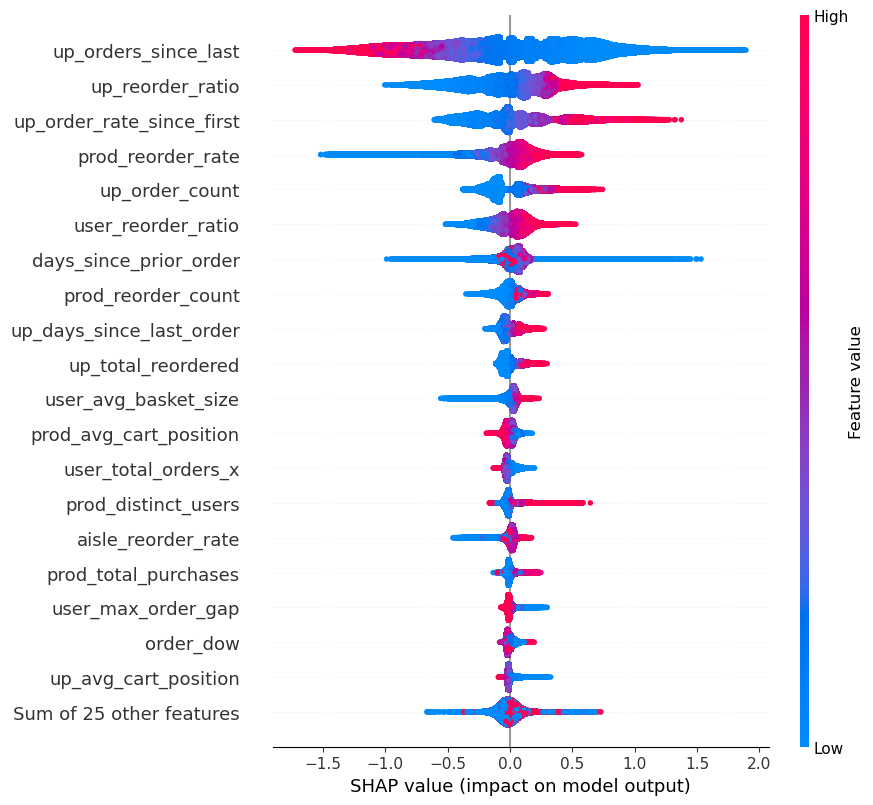

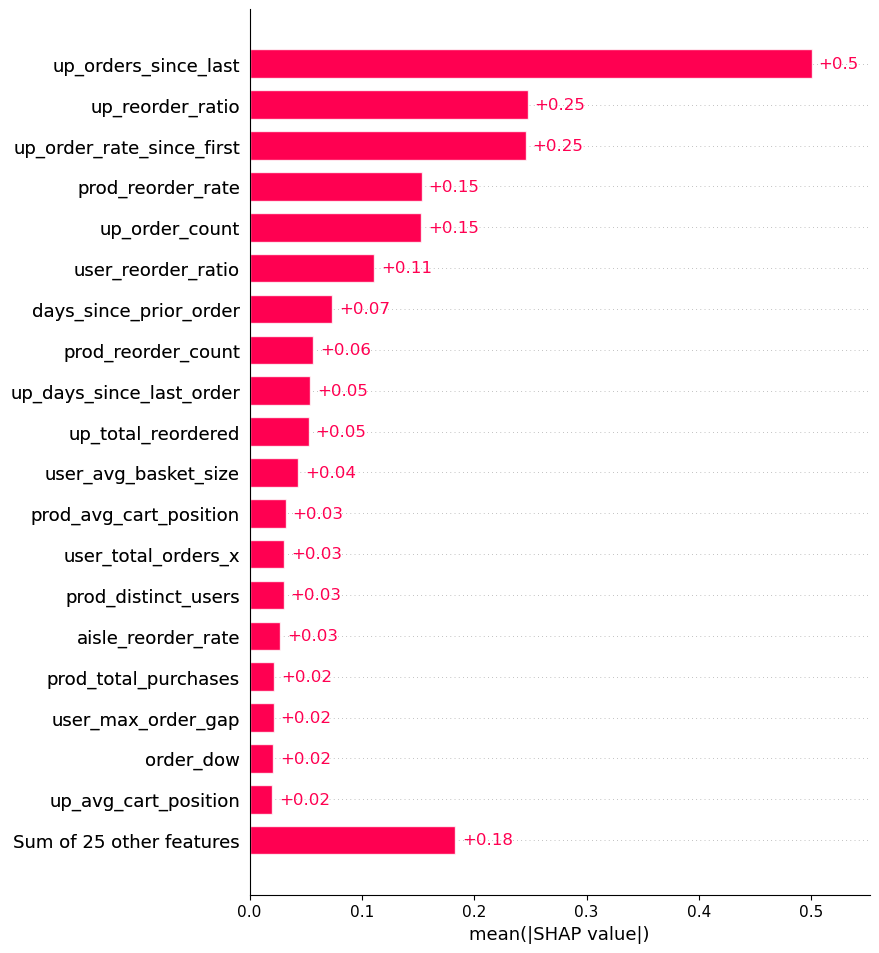

In [13]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# Create SHAP Explainer
explainer = shap.Explainer(model, X_train, feature_names=X_train.columns)

# Compute SHAP values on validation or test set
shap_values = explainer(X_val)

# Visualize feature importance

# Beeswarm plot: overall feature influence per prediction
shap.plots.beeswarm(shap_values, max_display=20)

# Bar plot: mean absolute SHAP value per feature
shap.plots.bar(shap_values, max_display=20)


LightXGM

In [15]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install --upgrade lightgbm

Note: you may need to restart the kernel to use updated packages.


In [17]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# Define the model
lgb_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model using callbacks instead of early_stopping_rounds
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Number of positive: 663059, number of negative: 6116669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.597581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6526
[LightGBM] [Info] Number of data points in the train set: 6779728, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.248094
[100]	valid_0's binary_logloss: 0.245402
[150]	valid_0's binary_logloss: 0.244858
[200]	valid_0's binary_logloss: 0.244503
[250]	valid_0's binary_logloss: 0.244242
[300]	valid_0's binary_logloss: 0.24403
[350]	valid_0's binary_logloss: 0.243876
[400]	valid_0's binary_logloss: 0.243738
[450]	valid_0's binary_logloss: 0.24361
[500]	vali

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               n_estimators=1000, n_jobs=-1, random_state=42, subsample=0.8)

In [18]:
import numpy as np
from sklearn.metrics import f1_score

# Predict probabilities on validation set
val_probs = lgb_model.predict_proba(X_val)[:, 1]

# Try thresholds between 0.1 and 0.9
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (val_probs >= t).astype(int)) for t in thresholds]

# Best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f" Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold:.2f}")


 Best F1 Score: 0.4495 at Threshold: 0.23


In [19]:
from sklearn.metrics import classification_report

# Apply best threshold to make predictions
val_preds_final = (val_probs >= best_threshold).astype(int)

# Detailed classification report
print(classification_report(y_val, val_preds_final))


              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93   1529168
         1.0       0.41      0.49      0.45    165765

    accuracy                           0.88   1694933
   macro avg       0.68      0.71      0.69   1694933
weighted avg       0.89      0.88      0.89   1694933



CATBoost

In [21]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [22]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    loss_function='Logloss',
    eval_metric='Logloss',
    random_seed=42,
    verbose=50,
    early_stopping_rounds=50
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)


0:	learn: 0.6337322	test: 0.6337144	best: 0.6337144 (0)	total: 2.13s	remaining: 35m 29s
50:	learn: 0.2501817	test: 0.2501478	best: 0.2501478 (50)	total: 1m 17s	remaining: 24m 11s
100:	learn: 0.2465182	test: 0.2465309	best: 0.2465309 (100)	total: 3m 3s	remaining: 27m 16s
150:	learn: 0.2456335	test: 0.2456731	best: 0.2456731 (150)	total: 4m 34s	remaining: 25m 40s
200:	learn: 0.2450609	test: 0.2451454	best: 0.2451454 (200)	total: 5m 59s	remaining: 23m 49s
250:	learn: 0.2446843	test: 0.2448062	best: 0.2448062 (250)	total: 7m 21s	remaining: 21m 56s
300:	learn: 0.2443874	test: 0.2445489	best: 0.2445489 (300)	total: 8m 48s	remaining: 20m 26s
350:	learn: 0.2441152	test: 0.2443232	best: 0.2443232 (350)	total: 10m 11s	remaining: 18m 51s
400:	learn: 0.2438781	test: 0.2441360	best: 0.2441360 (400)	total: 11m 38s	remaining: 17m 22s
450:	learn: 0.2436681	test: 0.2439827	best: 0.2439827 (450)	total: 13m 3s	remaining: 15m 53s
500:	learn: 0.2434777	test: 0.2438443	best: 0.2438443 (500)	total: 14m 29s	r

In [23]:
import numpy as np
from sklearn.metrics import f1_score

# Get predicted probabilities
val_probs_cat = cat_model.predict_proba(X_val)[:, 1]

# Threshold sweep
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (val_probs_cat >= t).astype(int)) for t in thresholds]

# Find best threshold and F1
best_idx = np.argmax(f1_scores)
best_threshold_cat = thresholds[best_idx]
best_f1_cat = f1_scores[best_idx]

print(f" CatBoost Best F1 Score: {best_f1_cat:.4f} at Threshold: {best_threshold_cat:.2f}")


 CatBoost Best F1 Score: 0.4489 at Threshold: 0.22


In [24]:
from sklearn.metrics import classification_report

val_preds_cat = (val_probs_cat >= best_threshold_cat).astype(int)
print(classification_report(y_val, val_preds_cat))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93   1529168
         1.0       0.40      0.50      0.45    165765

    accuracy                           0.88   1694933
   macro avg       0.67      0.71      0.69   1694933
weighted avg       0.89      0.88      0.88   1694933

